In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import pandas as pd
from scipy.integrate import odeint

### Opening predator-prey dataset

In [5]:
df = pd.read_csv('predator-prey-data.csv', index_col=False)
df.head()


,Unnamed: 0,t,x,y
0,0,0.000000,4.781635,3.035257
1,1,0.202020,6.114005,2.189746
2,2,0.404040,6.238361,1.478907
3,3,0.606061,5.520524,0.989836
4,4,0.808081,4.582546,0.957827


[[ 0.          4.78163509  3.03525736]
 [ 0.2020202   6.11400461  2.18974589]
 [ 0.4040404   6.23836095  1.47890677]
 [ 0.60606061  5.52052405  0.98983604]
 [ 0.80808081  4.58254575  0.95782741]
 [ 1.01010101  3.69549338  0.8089764 ]
 [ 1.21212121  2.73241063  0.5550991 ]
 [ 1.41414141  1.93007859  0.48259774]
 [ 1.61616162  1.61129364  0.54557416]
 [ 1.81818182  1.25280509  0.7378781 ]
 [ 2.02020202  0.99647646  0.61912135]
 [ 2.22222222  0.83616635  0.71381421]
 [ 2.42424242  0.55796464  0.80913925]
 [ 2.62626263  0.42574735  0.90709674]
 [ 2.82828283  0.29284544  1.20019798]
 [ 3.03030303  0.42998578  1.15551425]
 [ 3.23232323  0.29047429  1.4620071 ]
 [ 3.43434343  0.23623108  1.7790317 ]
 [ 3.63636364  0.44737461  1.90884655]
 [ 3.83838384  0.34584789  2.18036662]
 [ 4.04040404  0.26683052  2.45451334]
 [ 4.24242424  0.52841771  2.87645734]
 [ 4.44444444  0.65807025  3.34293736]
 [ 4.64646465  0.99468762  3.64158993]
 [ 4.84848485  1.56856111  3.9487383 ]
 [ 5.05050505  2.55628162

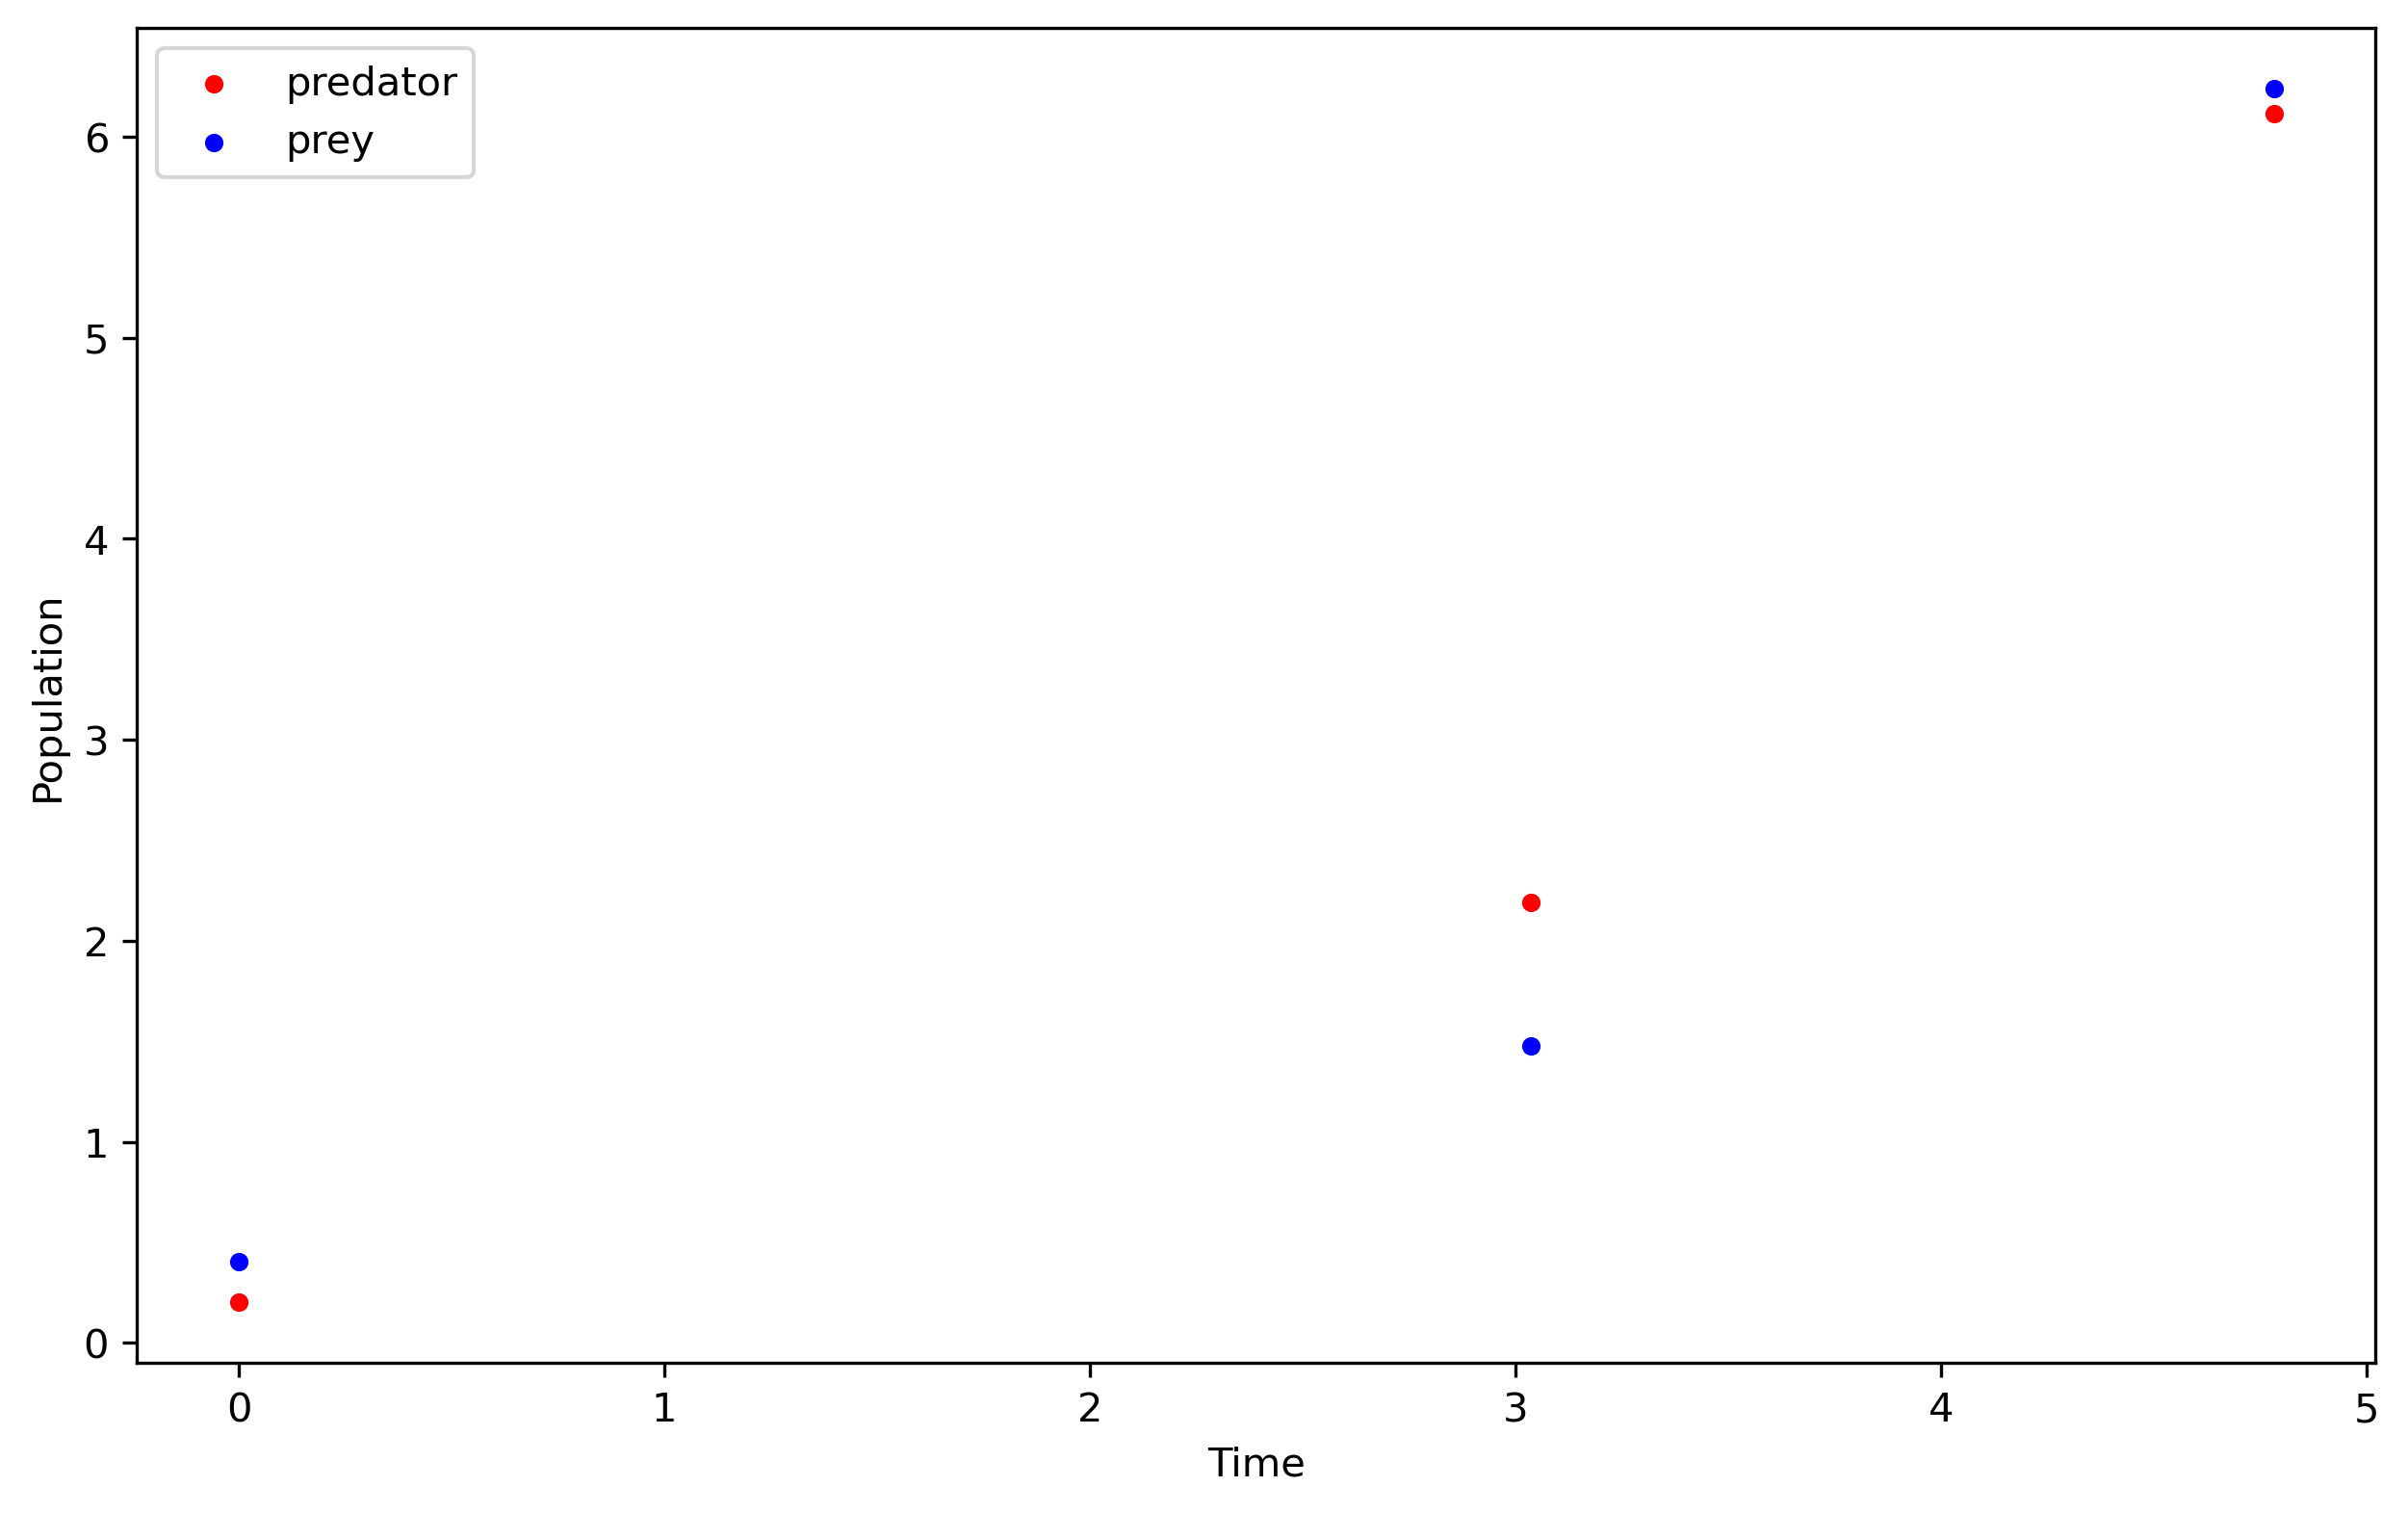

In [197]:
# Loading data into read-only numpy arrays
data = df[['t','x','y']].values
# data[1], data[2] = data[2].copy(), data[1].copy()
data.flags.writeable = False
print(data)

# Plotting
plt.figure(dpi =300, figsize=(10, 6))
point_width = 13
plt.scatter(data[0], data[1], label = 'predator', color = 'red', s =point_width)
plt.scatter(data[0], data[2], label = 'prey', color = 'blue', s=point_width)
plt.ylabel('Population')
plt.xlabel('Time')
plt.legend()


### Objective functions

#### Defining volterra equations function

In [90]:
def predator_prey_odes(initial_conditions,time ,alpha, beta, delta, gamma):
    
    x = initial_conditions[0]  # initial predator population
    y = initial_conditions[1]  # initial prey population
    dxdt = (alpha * x) - (beta * x * y)  # Predator ODE
    dydt = (delta * x * y) - (gamma * y)  # Predator ODE
    return [dxdt, dydt]


In [180]:
#Function that will return the data for predator and prey for a given set of parameters
def predator_prey_integration(time,initial_conditions,parameters): 
    alpha,beta,delta,gamma = parameters
    #odeint is now used as part of this function which returns the # of infected in the model
    results = odeint(predator_prey_odes,initial_conditions, time, args=(alpha,beta,delta,gamma)) 
    predator_values,prey_values = results[:,0], results[:,1]
    return np.array([predator_values,prey_values]).T



In [181]:
t, x ,y = data
initial_conditions = [x[0],y[0]]
alpha = 1.5
beta = 1.5
delta = 1.3
gamma = 1.4
parameters = [alpha, beta, delta, gamma]

# Using MSE
x = predator_prey_integration(t,initial_conditions,parameters)
print(x.shape)

# plt.scatter(x[0],x[1])
plt.plot(t, x[0])
plt.plot(t, x[1])

# plt.plot(t[0:9], x[0][0:9])
# plt.plot(t[0:9], x[1][0:9])
# plt.xlim(0,7.5)
# plt.xscale('log')

ValueError: too many values to unpack (expected 3)

### Defining objective functions

In [182]:
def negative_log_likelihood(actual, predicted, variance=1.0):
    '''Log likelyhood function'''
    # Assuming a normal distribution for simplicity
    log_likelihoods1 =norm.logpdf(actual[0], loc=predicted[0], scale=np.sqrt(variance))
    log_likelihoods2 = norm.logpdf(actual[1], loc=predicted[1], scale=np.sqrt(variance))
                                  
    return -np.sum((log_likelihoods1,log_likelihoods2))

def MSE(actual, predicted):
    '''Mean squared error'''
    return np.mean((actual - predicted)**2)

### Algorithms & Optimisation

In [204]:
def random_walk(parameters):
    lst = [parameter + np.random.normal(0, 1) for parameter in parameters]
    while all(element < 0 for x in lst):
        for indx in range(len(lst)):
            if lst[indx] < 0:
                while lst[indx] < 0:
                    lst[indx] = parameters[indx] + np.random.normal(0, 1)
    return lst
        
def hill_climbing(data, time, initial_conditions, parameters, objective, max_iterations=1000):
    '''Tries to find the best solution using random walker'''
    #Initalize starting parameter state
    scores = []
    x_n = parameters
    current_est = predator_prey_integration(time,initial_conditions, x_n)
    current_score = objective(data, current_est) 
    scores.append(current_score)
    for _ in range(max_iterations):
        # Generate a random walk for parameters
        x_n_1 = random_walk(parameters)
        
        # Calculate the current and next estimations
        new_estimation = predator_prey_integration(time,initial_conditions, x_n)
        new_score = objective(data, new_estimation)
        
        # If the next estimation is better, update the parameters
        if new_score < current_score:
            current_score = new_score
            x_n = x_n_1    
            scores.append(current_score)
    return x_n, current_score

 
        
def simulated_annealing(search_space,function,temp):
    scale = np.sqrt(temp) #Scaling factor for random movement. We square root the temperature to allow for a smoother decrease in scaling as the temperature decreases
    start = np.random.choice(search_space) #Start with a random x value 
    x = start * 1
    cur = function(x) #The function value of the current x solution
    history = [x] #Stores previously searched x values

    for i in range (1000):
        proposal = x + np.random.normal() * scale #A new solutiom is generated by adding a normally distributed random value to the current solution x
        delta = function(proposal) - cur

        if proposal < 0 or proposal > 1:
           proposal = x # Reject proposal if it is not in the correct range
    
        elif delta < 0:
            x = proposal ##Accept proposal

        elif np.exp(delta/temp) < np.random.rand(): #else if it is not negative (meaning it is a bad proposal), we may still accept it with the probability in the brackets, which depends on how high temp is
            x = proposal #Accept proposal

        
        cur = function(x)
        temp = 0.9 * temp #Cool temperature
        history.append(temp) #Add to history
    
    return x, history
        
        

In [218]:
# def random_walk(parameters):
#     return [parameter + np.random.normal(0, 1) for parameter in parameters]

def random_walk(parameters):
    lst = [parameter + np.random.normal(0, 1) for parameter in parameters]
    # Ensure all elements are positive
    while any(x <= 0 for x in lst):
        for indx in range(len(lst)):
            if lst[indx] <+ 0:
                lst[indx] = max(0, parameters[indx] + np.random.normal(0, 1))

    return lst

def hill_climbing(data, time, initial_conditions, parameters, objective, max_iterations=1000):
    '''Tries to find the best solution using random walker'''
    # Initialize starting parameter state
    scores = []
    x_n = parameters
    
    current_est = predator_prey_integration(time, initial_conditions, x_n)
    current_score = objective(data, current_est)
    scores.append(current_score)

    for _ in range(max_iterations):
        # Generate a random walk for parameters
        x_n_1 = random_walk(x_n)

        # Calculate the current and next estimations
        current_est = predator_prey_integration(time, initial_conditions, x_n)
        new_estimation = predator_prey_integration(time, initial_conditions, x_n_1)
        new_score = objective(data, new_estimation)

        # If the next estimation is better, update the parameters
        if new_score < current_score:
            current_score = new_score
            x_n = x_n_1
            scores.append(current_score)

    return x_n, scores


In [219]:
input_data = data[:,1:3]
initial_conditions = [input_data[0][0], input_data[0][1]]

alpha = 0.5
beta = 0.5
delta = 1
gamma = 0.5
parameters = [alpha, beta, delta, gamma]

# Using MSE
x_best, scores = hill_climbing(input_data, t, input_data[0], parameters, MSE, max_iterations=1000)
print(x_best,scores)

C:\Users\Aleks\AppData\Local\Temp\ipykernel_11892\1265267204.py:11: RuntimeWarning: overflow encountered in square
  return np.mean((actual - predicted)**2)
C:\Users\Aleks\AppData\Local\Temp\ipykernel_11892\1103727231.py:6: RuntimeWarning: overflow encountered in scalar multiply
  dydt = (delta * x * y) - (gamma * y)  # Predator ODE
C:\Users\Aleks\AppData\Local\Temp\ipykernel_11892\1103727231.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  dxdt = (alpha * x) - (beta * x * y)  # Predator ODE
C:\Users\Aleks\AppData\Local\Temp\ipykernel_11892\1103727231.py:6: RuntimeWarning: invalid value encountered in scalar subtract
  dydt = (delta * x * y) - (gamma * y)  # Predator ODE
C:\Users\Aleks\AppData\Local\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0, 0.31568889809211, 1.6242813957462225, 6.2913817771374445] [8.115484617682851, 4.9521091058501465, 4.542790997667599, 3.9262365971306066, 3.851902949809886, 3.7067389333392295, 3.691785271862443, 3.658800107833335, 3.638125275656851]


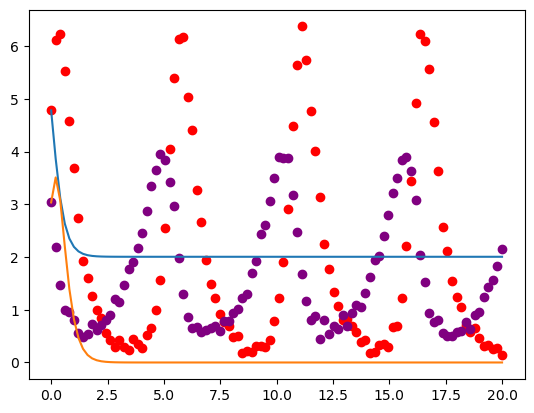

In [220]:
# t, x ,y = data
initial_conditions = [input_data[0][0], input_data[0][1]]
t = data[:,0]


alpha = 1.5
beta = 1.5
delta = 1.3
gamma = 1.4
parameters = x_best

# Using MSE
x = predator_prey_integration(t,initial_conditions,parameters)

plt.plot(t, x[:,0])
plt.plot(t, x[:,1])


plt.scatter(t, data[:,1], color= 'red')
plt.scatter(t, data[:,2], color= 'purple')